In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.STL10(
    root="data",
    split="train", #수정
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.STL10(
    root="data",
    split="train", #수정
    download=True,
    transform=ToTensor(),
)

100%|██████████| 2.64G/2.64G [03:52<00:00, 11.4MB/s] 


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 96, 96])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

In [11]:
from torchvision import datasets, transforms, models
from torchvision.models import vgg16
from torchvision.models import vgg16_bn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define model

# 실험 1 - VGG16 / BN off / Dropout 0.5
model1 = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1) # BN off
model1.classifier[2] = nn.Dropout(p=0.5)
model1.classifier[5] = nn.Dropout(p=0.5)
model1.classifier[6] = nn.Linear(4096, 10)

# 실험 2 - VGG16 / BN off / Dropout 0.3
model2 = vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1) # BN off
model2.classifier[2] = nn.Dropout(p=0.3)
model2.classifier[5] = nn.Dropout(p=0.3)
model2.classifier[6] = nn.Linear(4096, 10)

# 실험 3 - VGG16 / BN on / Dropout 0.5
model3 = vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1) # BN on
model3.classifier[2] = nn.Dropout(p=0.5)
model3.classifier[5] = nn.Dropout(p=0.5)
model3.classifier[6] = nn.Linear(4096, 10)

# 실험 4 - VGG16 / BN on / Dropout 0.3
model4 = vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1) # BN on
model4.classifier[2] = nn.Dropout(p=0.3)
model4.classifier[5] = nn.Dropout(p=0.3)
model4.classifier[6] = nn.Linear(4096, 10)

Using cuda device


In [12]:
print("model1: ", model1.classifier)
print("model2: ", model2.classifier)
print("model3: ", model3.classifier)
print("model4: ", model4.classifier)

model1:  Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)
model2:  Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)
model3:  Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)


## Optimizing the Model Parameters

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-3)

In [49]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct


In [50]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= len(dataloader)
    correct /= size
    return test_loss, correct


In [64]:
epochs = 10
model4 = model4.to(device)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_loss, train_acc = train(train_dataloader, model4, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model4, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

print("Done!")


Epoch 1
-------------------------------
Train Acc: 12.40%, Test Acc: 13.26%
Epoch 2
-------------------------------
Train Acc: 12.22%, Test Acc: 13.26%
Epoch 3
-------------------------------
Train Acc: 12.20%, Test Acc: 13.26%
Epoch 4
-------------------------------
Train Acc: 12.72%, Test Acc: 13.26%
Epoch 5
-------------------------------
Train Acc: 12.74%, Test Acc: 13.26%
Epoch 6
-------------------------------
Train Acc: 12.66%, Test Acc: 13.26%
Epoch 7
-------------------------------
Train Acc: 12.34%, Test Acc: 13.26%
Epoch 8
-------------------------------
Train Acc: 12.02%, Test Acc: 13.26%
Epoch 9
-------------------------------
Train Acc: 12.44%, Test Acc: 13.26%
Epoch 10
-------------------------------
Train Acc: 11.78%, Test Acc: 13.26%
Done!


## Saving Models

In [29]:
torch.save(model1.state_dict(), "model1.pth")
print("Saved PyTorch Model State to model1.pth")

Saved PyTorch Model State to model1.pth


## Loading Models

In [30]:
model1.load_state_dict(torch.load("model1.pth", weights_only=True))

<All keys matched successfully>

In [35]:
classes = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck",
]

model1 = model1.to(device)
model1.eval()

x, y = test_data[0]

with torch.no_grad():
    x = x.unsqueeze(0).to(device)   # (1, C, H, W)
    pred = model1(x)

    predicted = classes[pred.argmax(1).item()]
    actual = classes[y]

print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "bird", Actual: "bird"


## TEST 시각화

test 1: VGG16 / BN off / Dropout 0.5


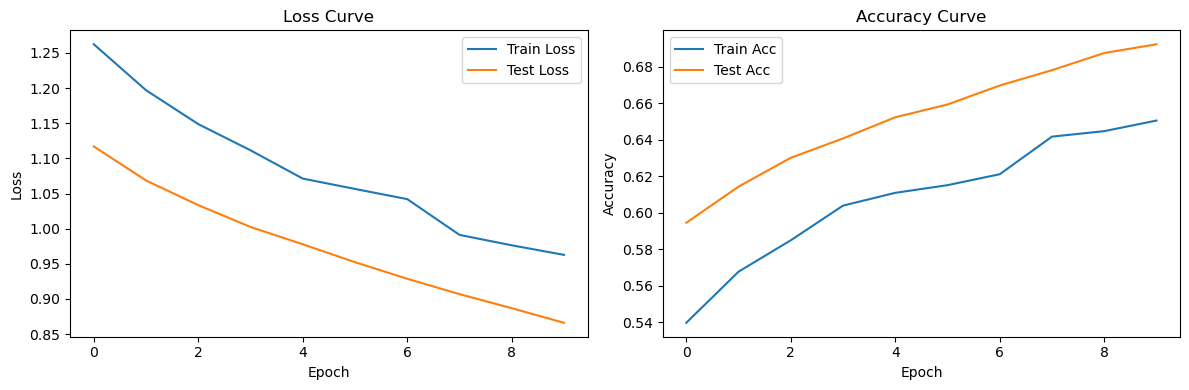

In [56]:
import matplotlib.pyplot as plt

print("test 1: VGG16 / BN off / Dropout 0.5")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 🔹 Loss curve
axes[0].plot(train_losses, label="Train Loss")
axes[0].plot(test_losses, label="Test Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()

# 🔹 Accuracy curve
axes[1].plot(train_accs, label="Train Acc")
axes[1].plot(test_accs, label="Test Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].legend()

plt.tight_layout()
plt.show()


test 2: VGG16 / BN off / Dropout 0.3


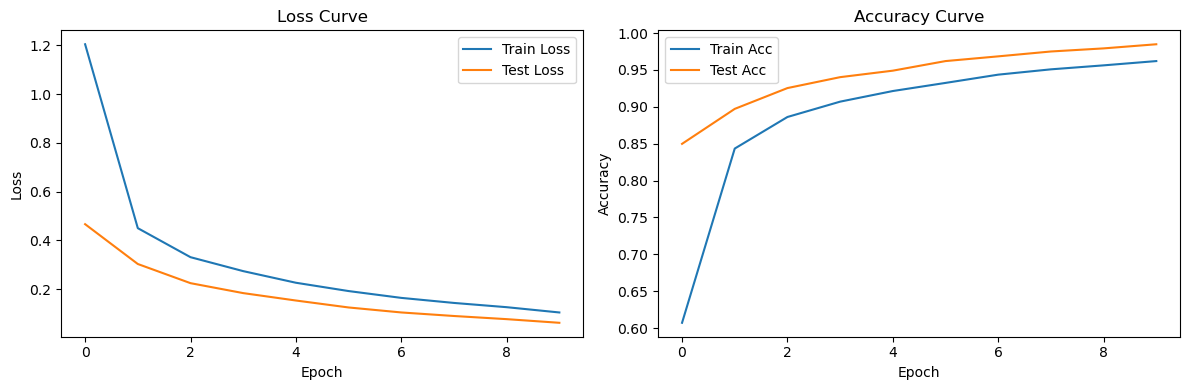

In [59]:
print("test 2: VGG16 / BN off / Dropout 0.3")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 🔹 Loss curve
axes[0].plot(train_losses, label="Train Loss")
axes[0].plot(test_losses, label="Test Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()

# 🔹 Accuracy curve
axes[1].plot(train_accs, label="Train Acc")
axes[1].plot(test_accs, label="Test Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

test 3: VGG16 / BN on / Dropout 0.5


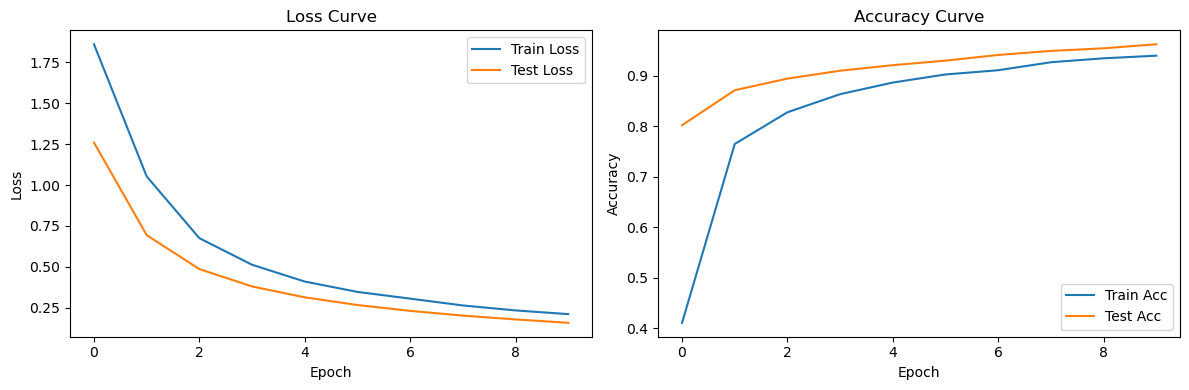

In [62]:
print("test 3: VGG16 / BN on / Dropout 0.5")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 🔹 Loss curve
axes[0].plot(train_losses, label="Train Loss")
axes[0].plot(test_losses, label="Test Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()

# 🔹 Accuracy curve
axes[1].plot(train_accs, label="Train Acc")
axes[1].plot(test_accs, label="Test Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

test 4: VGG16 / BN on / Dropout 0.3


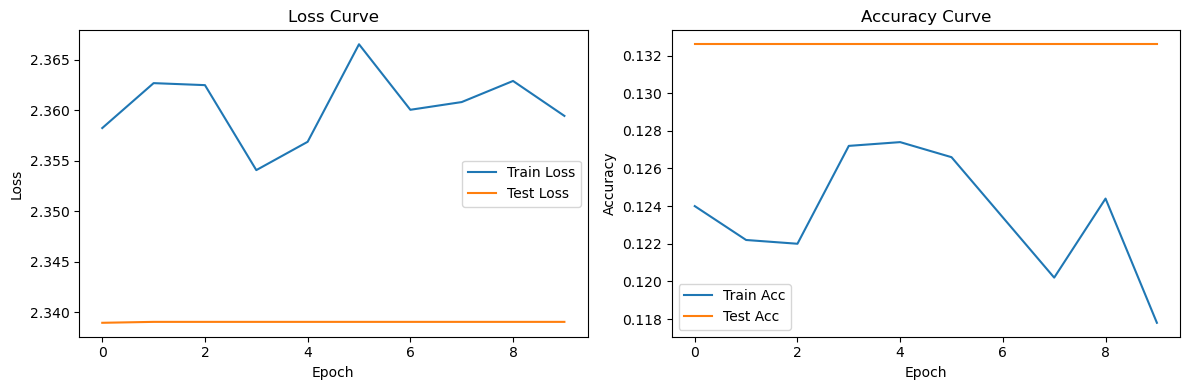

In [65]:
print("test 4: VGG16 / BN on / Dropout 0.3")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 🔹 Loss curve
axes[0].plot(train_losses, label="Train Loss")
axes[0].plot(test_losses, label="Test Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()

# 🔹 Accuracy curve
axes[1].plot(train_accs, label="Train Acc")
axes[1].plot(test_accs, label="Test Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

- 결과 1 (test 1 vs test 2): **BN off** & **Dropout 0.3** > Dropout 0.5  
→ BN이 없을 때는 Dropout이 과도하면 표현력 손실이 커짐  
→ 0.5에서는 유효한 특징까지 제거되어 학습 안정성과 성능이 저하됨  
→ 적당한 Dropout 0.3이 과적합 억제와 표현력 유지의 균형점임  
→ Dropout 강도와 표현력 손실은 연관이 있음  

- 결과 2 (test 3 vs test 4): **BN on** & Dropout 0.3 < **Dropout 0.5**  
→ BN이 활성화되면 BN이 분포를 정규화하여 강한 Dropout에도 학습이 유지됨  
→ 이 조건에서는 Dropout 0.5가 오히려 일반화에 유리하게 작용함  
→ BN은 강한 정규화 기법과의 공존에 유리함  

- 결과 3 (test 2 vs test 4): **dropout = 0.3** & **BN off** > BN on  
→ Dropout이 약한 경우 BN의 추가 정규화가 과도해짐

- 결과 4 (test 1 vs test 3): **dropout = 0.5** & BN off < **BN on**
  - dropout = 0.3 으로 고정하였을 때는 BN off 가 더 성능이 좋음. 그러나 dropout = 0.5 에서는 BN on 이 성능이 더 좋음
  - 적절한 수치의 조합이 더 중요함